# Gibbs Sampling

In [1]:
import os
import pandas as pd
import numpy as np
from numpy import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
blue_color = mcolors.TABLEAU_COLORS['tab:blue']
import corner

from collections import namedtuple, Counter
from scipy import stats


In [2]:
#define data directory and file
work_dir = os.getcwd()

data_file = os.path.join(work_dir, 'data/GRB_data.txt')

#retrieve data
data = np.genfromtxt(data_file)
logT90, dlogT90, HR = data.T

### plot corner

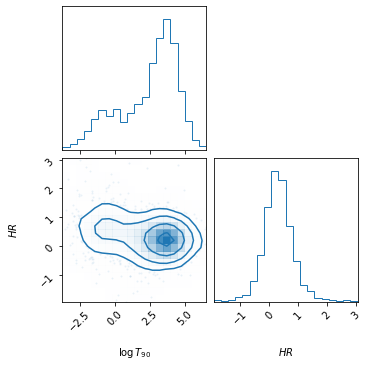

In [3]:
corner.corner(np.array([logT90, HR]).T, 
                       labels=[
                        r"$\log T_{90}$",
                        r"$HR$",],
                       bins = 20, 
                       color = blue_color, 
                      title_kwargs={"fontsize": 12}, 
              max_n_ticks=5,
              smooth=1,
             )
plt.rcParams['font.size']=15

## Collapsed Gibbs Sampling

### 2 components

In [4]:
SuffStat = namedtuple('SuffStat', 'theta N')

def initial_state(num_clusters=3, alpha=1.0):
    cluster_ids = range(num_clusters)

    state = {
        'cluster_ids_': cluster_ids,
        'data_': logT90,
        'num_clusters_': num_clusters,
        'cluster_variance_': 1,
        'alpha_': alpha,
        'hyperparameters_': {
            "mean": 0,
            "variance": 1,
        },
        'suffstats': {cid: None for cid in cluster_ids},
        'assignment': [random.choice(cluster_ids) for _ in data],
        'pi': {cid: alpha / num_clusters for cid in cluster_ids},
    }
    update_suffstats(state)
    return state

def update_suffstats(state):
    for cluster_id, N in iter(Counter(state['assignment']).items()):
        points_in_cluster = [x 
            for x, cid in zip(state['data_'], state['assignment'])
            if cid == cluster_id
        ]
        mean = np.array(points_in_cluster).mean()
        
        state['suffstats'][cluster_id] = SuffStat(mean, N)

In [5]:
def log_predictive_likelihood(data_id, cluster_id, state):
    """Predictive likelihood of the data at data_id is generated
    by cluster_id given the currenbt state.
    
    From Section 2.4 of 
    http://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf
    """
    ss = state['suffstats'][cluster_id]
    hp_mean = state['hyperparameters_']['mean']
    hp_var = state['hyperparameters_']['variance']
    param_var = state['cluster_variance_']
    x = state['data_'][data_id]
    return _log_predictive_likelihood(ss, hp_mean, hp_var, param_var, x)


def _log_predictive_likelihood(ss, hp_mean, hp_var, param_var, x):
    posterior_sigma2 = 1 / (ss.N * 1. / param_var + 1. / hp_var)
    predictive_mu = posterior_sigma2 * (hp_mean * 1. / hp_var + ss.N * ss.theta * 1. / param_var)
    predictive_sigma2 = param_var + posterior_sigma2
    predictive_sd = np.sqrt(predictive_sigma2)
    return stats.norm(predictive_mu, predictive_sd).logpdf(x)


def log_cluster_assign_score(cluster_id, state):
    """Log-likelihood that a new point generated will
    be assigned to cluster_id given the current state.
    """
    current_cluster_size = state['suffstats'][cluster_id].N
    num_clusters = state['num_clusters_']
    alpha = state['alpha_']
    return np.log(current_cluster_size + alpha * 1. / num_clusters)

In [6]:
def cluster_assignment_distribution(data_id, state):
    """Compute the marginal distribution of cluster assignment
    for each cluster.
    """
    scores = {}
    for cid in state['suffstats'].keys():
        scores[cid] = log_predictive_likelihood(data_id, cid, state)
        scores[cid] += log_cluster_assign_score(cid, state)
    scores = {cid: np.exp(score) for cid, score in iter(scores.items())}
    normalization = 1.0/sum(scores.values())
    scores = {cid: score*normalization for cid, score in iter(scores.items())}
    return scores

def add_datapoint_to_suffstats(x, ss):
    """Add datapoint to sufficient stats for normal component
    """
    return SuffStat((ss.theta*(ss.N)+x)/(ss.N+1), ss.N+1)


def remove_datapoint_from_suffstats(x, ss):
    """Remove datapoint from sufficient stats for normal component
    """
    return SuffStat((ss.theta*(ss.N)-x*1.0)/(ss.N-1), ss.N-1)

In [7]:
def gibbs_step(state):
    pairs = zip(state['data_'], state['assignment'])
    for data_id, (datapoint, cid) in enumerate(pairs):

        state['suffstats'][cid] = remove_datapoint_from_suffstats(datapoint, 
                                                                  state['suffstats'][cid])
        scores = cluster_assignment_distribution(data_id, state).items()
        labels, scores = zip(*scores)
        cid = random.choice(labels, p=scores)
        state['assignment'][data_id] = cid
        state['suffstats'][cid] = add_datapoint_to_suffstats(state['data_'][data_id], state['suffstats'][cid])

In [8]:
def plot_clusters(state):
    gby = pd.DataFrame({
            'data': state['data_'], 
            'assignment': state['assignment']}
        ).groupby(by='assignment')['data']
    hist_data = [gby.get_group(cid).tolist() 
                 for cid in gby.groups.keys()]
    plt.hist(hist_data, 
             bins=20,
             histtype='stepfilled', alpha=.5 )

## Optimal Number of Clusters

In [9]:
def log_cluster_assign_score_dp(cluster_id, state):
    """Log-likelihood that a new point generated will
    be assigned to cluster_id given the current state.
    """
    if cluster_id == "new":
        return np.log(state["alpha_"])
    else:
        return np.log(state['suffstats'][cluster_id].N)

In [10]:
def log_predictive_likelihood_dp(data_id, cluster_id, state):
    """Predictive likelihood of the data at data_id is generated
    by cluster_id given the currenbt state.
    
    From Section 2.4 of 
    http://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf
    """
    if cluster_id == "new":
        ss = SuffStat(0, 0)
    else:
        ss = state['suffstats'][cluster_id]
        
    hp_mean = state['hyperparameters_']['mean']
    hp_var = state['hyperparameters_']['variance']
    param_var = state['cluster_variance_']
    x = state['data_'][data_id]
    return _log_predictive_likelihood(ss, hp_mean, hp_var, param_var, x)

In [11]:
def cluster_assignment_distribution_dp(data_id, state):
    """Compute the marginal distribution of cluster assignment
    for each cluster.
    """
    scores = {}
    cluster_ids = list(state['suffstats'].keys()) + ['new']
    for cid in cluster_ids:
        scores[cid] = log_predictive_likelihood_dp(data_id, cid, state)
        scores[cid] += log_cluster_assign_score_dp(cid, state)
    scores = {cid: np.exp(score) for cid, score in iter(scores.items())}
    normalization = 1.0/sum(scores.values())
    scores = {cid: score*normalization for cid, score in iter(scores.items())}
    return scores

In [12]:
def create_cluster(state):
    state["num_clusters_"] += 1
    cluster_id = max(state['suffstats'].keys()) + 1
    state['suffstats'][cluster_id] = SuffStat(0, 0)
    list(state['cluster_ids_']).append(cluster_id)
    return cluster_id

def destroy_cluster(state, cluster_id):
    state["num_clusters_"] = 1
    del state['suffstats'][cluster_id]
    list(state['cluster_ids_']).remove(cluster_id)
    
def prune_clusters(state):
    for cid in state['cluster_ids_']:
        if state['suffstats'][cid].N == 0:
            destroy_cluster(state, cid)

In [13]:
def sample_assignment(data_id, state):
    """Sample new assignment from marginal distribution.
    If cluster is "`new`", create a new cluster.
    """
    scores = cluster_assignment_distribution_dp(data_id, state).items()
    labels, scores = zip(*scores)
    cid = random.choice(labels, p=scores)
    if cid == "new":
        return create_cluster(state)
    else:
        return int(cid)

def gibbs_step_dp(state):
    """Collapsed Gibbs sampler for Dirichlet Process Mixture Model
    """
    pairs = zip(state['data_'], state['assignment'])
    for data_id, (datapoint, cid) in enumerate(pairs):
        state['suffstats'][cid] = remove_datapoint_from_suffstats(datapoint, state['suffstats'][cid])
        prune_clusters(state)
        cid = sample_assignment(data_id, state)
        state['assignment'][data_id] = cid
        state['suffstats'][cid] = add_datapoint_to_suffstats(state['data_'][data_id], state['suffstats'][cid])

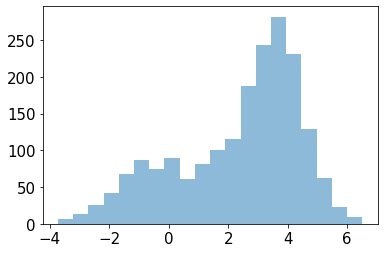

In [37]:
state = initial_state(num_clusters=1, alpha=.01)
plot_clusters(state)

  0%|          | 0/100 [00:00<?, ?it/s]

100

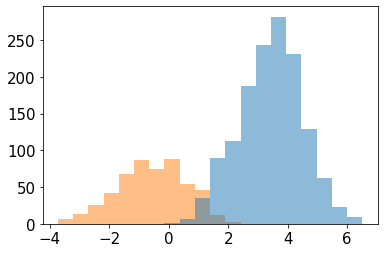

In [38]:
step = 0
for _ in tqdm(range(100)): 
    try:
        gibbs_step_dp(state)
        step+=1
    except:
        pass

plot_clusters(state)
step